<a href="https://colab.research.google.com/github/TetianaHrunyk/NeuralMetaphorsDetection/blob/master/MD1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
from torch.utils.data import DataLoader
import regex

In [ ]:
import matplotlib.pyplot as plt

def plot_errors(title, training_losses, test_loss=None, block=True):
    plt.figure(num=title)
    plt.plot(training_losses, label='Training loss')

    if test_loss:
        plt.plot([test_loss]*len(training_losses), label='Test loss')

    plt.tight_layout()
    plt.legend()
    plt.show(block=block)

# Load the data, create custom data set

In [ ]:
data_path='https://raw.githubusercontent.com/TetianaHrunyk/NeuralMetaphorsDetection/master/'

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, path, nrows=None, tokenizer=None):
    self.text = pd.read_csv(path, header=None, names=["txt"], dtype='str', nrows=nrows)
    self.tokenizer = tokenizer

  def __len__(self):
    return self.text.shape[0]

  def __getitem__(self, idx):
    tokenized = self.tokenizer(self.text.txt.iloc[idx])
    labels = " ".join([str(int(word.startswith("M_"))) for word in tokenized])
    txt = " ".join([word.replace("M_", "").lower() for word in tokenized])
    return labels, txt


In [ ]:
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

In [ ]:
TAGS = ["0", "1"]
train_data = CustomDataset(data_path+"vuamc_train.csv", nrows=102, tokenizer=en_tokenizer)
test_data = CustomDataset(data_path+"vuamc_test.csv",  nrows=10, tokenizer=en_tokenizer)

# Build Vocab

In [ ]:
def build_vocab(data):
  counter = Counter()
  for row in data:
      counter.update(row[1].split(" "))
  return Vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'], min_freq=1)

In [ ]:
vocab = build_vocab(train_data)

# Data Loader

In [ ]:
text_pipeline = lambda x: [vocab[token] for token in x.rstrip("\n").split(" ")]
label_pipeline = lambda x: [ int(l) for l in x.split(" ")]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list = [], []
    for labels, text in batch:
        processed_text = text_pipeline(text)
        text_tensor = torch.tensor(processed_text, dtype=torch.int64)
        text_list.append(text_tensor)        
        
        processed_labels=label_pipeline(labels)
        label_tensor = torch.tensor(processed_labels, dtype=torch.int64)
        label_list.append(label_tensor)

    label_list = torch.cat(label_list)
    text_list = torch.cat(text_list)
    
    return label_list.to(device), text_list.to(device)

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=8, shuffle=False, collate_fn=collate_batch)

In [ ]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

class LSTMTagger_Embed(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger_Embed, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim)                                                                

        self.hidden2tag =  nn.Linear(hidden_dim, tagset_size) 
        self.hidden = self.init_hidden()         

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_dim),                                     
                torch.zeros(1, 1, self.hidden_dim))

    def forward(self, sentence):
        embeds =  self.word_embeddings(sentence)                                                                                               
        lstm_out, self.hidden =  self.lstm(embeds.view(len(sentence), 1, -1))               
        tag_prediction = self.hidden2tag(lstm_out.view(len(sentence), -1))                     
        tag_scores = F.log_softmax(tag_prediction, dim=1)                       
        return tag_scores

    def fit (self, n_epochs, dataloader, loss_function, optimizer):
        self.train()
        train_losses = []
        for epoch in range(n_epochs):
            for i, (tags, sentence) in enumerate(dataloader):
                self.zero_grad()
                self.hidden = self.init_hidden()
                
                tag_scores = self(sentence)
                loss = loss_function(tag_scores, tags)
                train_losses.append(loss)
                
                loss.backward()
                optimizer.step()

            print('Epoch %d, loss: %0.4f' % (epoch + 1, loss))
        
        return train_losses

    def report_accuracy(self, dataloader, n=None, print_data=False):
        if n==None:
          n=TRAIN_DATA_LEN
        with torch.no_grad():
            total, total_correct, total_exact_correct = 0, 0, 0
            TP, TN, FP, FN = 0, 0, 0, 0
            for tags, sentence in dataloader:
                scores = self(sentence)
                out = torch.argmax(scores, dim=1).tolist()
                targets = tags.tolist()
                
                correct = 0
                length = len(targets)
                
                for i in range(length):
                    if out[i] == targets[i]:
                      correct += 1
                      if targets[i] == 1:
                        TP += 1
                      elif targets[i] == 0:
                        TN += 1
                    else:
                      if targets[i] == 1:
                        FN += 1
                      elif targets[i] == 0:
                        FP += 1

                if (print_data):
                    print('data: ' + str(dict(zip(sentence, tags))))
                    print('pred: ' + str(dict(zip(sentence, out))))
                    print('Correct: %d of %d' % (correct, length))

                total += length
                total_correct += correct
                if correct == length:
                    total_exact_correct += 1

            print('Accuracy (exact): %d / %d, %0.4f' % (total_exact_correct, n, total_exact_correct / n))
            print('Accuracy: %d / %d, %0.4f \n' % (total_correct, total, total_correct / total))
            print("{:5}| {:10} | {:10}\n{}".format("", "T", "F", "-"*30))
            print("{:5}| {:10} | {:10}".format("P", TP, FP))
            print("{:5}| {:10} | {:10}\n".format("N", TN, FN))
            
            den = 0.00001 if TP+FP == 0 else TP+FP
            print("Precision: ", round(TP/den, 2))
            den = 0.00001 if TP+FN == 0 else TP+FN
            print("Recall: ", round(TP/den, 2))
            den = 0.00001 if TP+TN+FP+FN == 0 else TP+TN+FP+FN
            print("F1: ", 2*TP/den)


# Train model

Epoch 1, loss: 0.4330
Epoch 2, loss: 0.3369
Epoch 3, loss: 0.2993

Accuracy for training data
Accuracy (exact): 0 / 102, 0.0000
Accuracy: 2152 / 2436, 0.8834 

     | T          | F         
------------------------------
P    |          0 |          0
N    |       2152 |        284

Precision:  0.0
Recall:  0.0
F1:  0.0


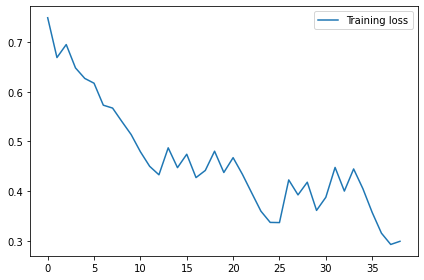

In [ ]:
torch.manual_seed(1)

HIDDEN_DIM = 10  
EMBEDDING_DIM = 64 
n_epochs = 3      
TRAIN_DATA_LEN = len(train_data)
TEST_DATA_LEN = len(test_data)
TAGS = [0, 1]


model = LSTMTagger_Embed(EMBEDDING_DIM, HIDDEN_DIM, len(vocab), len(TAGS))

optimizer = optim.SGD(model.parameters(), lr=0.1)            
loss_function = nn.NLLLoss()      

train_losses = model.fit(n_epochs, train_dataloader, loss_function, optimizer)

print("\nTraining Accuracy")
model.report_accuracy(train_dataloader)
plot_errors(training_losses=train_losses, title='Training loss')
#print("\nAccuracy for testing data")
#model.report_accuracy(testing_data, TAGS)
